In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import covariance_generation as cov
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [2]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)

other_curves_dict = {'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method,
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou}

In [44]:
# Rotation Curve Plotting Function

def plot_rotation_curve(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False,
                        ):


    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    
    bin_setup = load_bin_settings(mcmc_runs[0], is_print=False)
    bin_centers_r = bin_setup['bin_centers_r']

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    mcmc_fmts = ['o', 'd']
    for i_path, path in enumerate(mcmc_runs):

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-100, 100, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)
        

    plt.xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.xaxis.set_major_locator(MultipleLocator(1e3))
    ax.yaxis.set_major_locator(MultipleLocator(5))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    if(display_bin_edges):
        if(is_last_merged):
            # Remove middle boundary
            bin_edges_r = np.delete(bin_edges_r, -2)
        ax.vlines(bin_edges_r, 205, 255, linestyles='dashed', alpha=0.5, colors='grey')   
        #x_ticks = np.round(bin_edges_r)
        #ax.set_xticks(x_ticks)

    lit_fmts = ['+', 'x', '^', 'v', '.']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 16]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if(key == 'Eilers et al. 2018'):
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    plt.legend(prop={'size': 9})

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    plt.xlim(4000, 16000)
    plt.rcParams["axes.grid"] = False




def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

In [4]:
# Rotation Curve Plotting Function

def plot_rotation_curve_shaded(mcmc_runs, 
                            labels, 
                            burnin, 
                            extra_dims=[], 
                            display_eilers=False, 
                            display_bin_edges=False):


    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    
    bin_setup = load_bin_settings(mcmc_runs[0], is_print=False)
    bin_centers_r = bin_setup['bin_centers_r']

    mcmc_fmts = ['o', 'd']
    for i_path, path in enumerate(mcmc_runs):

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-100, 100, len(mcmc_runs))
            x_offset = 0
            x_values = bin_centers_r + x_offset


        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        plt.plot(x_values, -y_values, 'k-', color=colors[i_path], alpha=0.6)
        plt.fill_between(x_values, 
                        -y_values-y_error[0], 
                        -y_values+y_error[1],
                        color=colors[i_path],
                        alpha=0.3, label=labels[i_path]
                    )

        # plt.errorbar(x_values, -y_values,
        #             yerr= y_error,
        #             fmt=mcmc_fmts[i_path], 
        #             c=colors[i_path], 
        #             label=labels[i_path], 
        #             markersize = 8)

    plt.xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.xaxis.set_major_locator(MultipleLocator(1e3))
    ax.yaxis.set_major_locator(MultipleLocator(5))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    if(display_bin_edges):
        ax.vlines(bin_edges_r, 205, 255, linestyles='dashed', alpha=0.5, colors='grey')   
        #x_ticks = np.round(bin_edges_r)
        #ax.set_xticks(x_ticks)

    lit_fmts = ['+', 'x', '^', 'v', '.']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'black']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 16]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if(key == 'Eilers et al. 2018'):
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key)

    plt.legend(prop={'size': 9})

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    plt.xlim(4000, 16000)
    plt.rcParams["axes.grid"] = False




def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

---
# Curves With Varying $R_0$

In [ ]:
# R_0 = 7.8 kpc
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-09-53_range0.3'

# R_0 = 8.275 kpc
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-16-18-18-52_range0.3'

# R_0 = 8.5 kpc
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-48-32_range0.3'

paths=[path1, path2, path3]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path3, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']


In [ ]:
plot_walkers(samplers[1], 0)

In [ ]:
extra_dims = [2, 2, 2]
plot_rotation_curve(False, 
                    paths, 
                    ['DR3 Result ($R_0 = 7.8 kpc$)', 
                    'DR3 Result ($R_0 = 8.275 kpc$)', 
                    'DR3 Result ($R_0 = 8.5 kpc$)'],
                    [4000, 12000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

## Tests With Small Sample (1%)

In [ ]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-09-53_range0.3'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path3, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

In [ ]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-02-15-50-22_48'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')


reader = emcee.backends.HDFBackend(samplers[0], read_only=True)
samples_data = reader.get_chain(discard = 2000)
print("Sampler shape: {}".format(samples_data.shape))

fig,ax = plt.subplots(figsize=(10,10))
 
ax.plot(samples_data[:, :, -2], "k", alpha=0.3)
ax.ticklabel_format(useOffset=False)
plt.show()

In [ ]:
plot_walkers(samplers[0], 0)

In [ ]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-02-23-50-30_48'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')



reader = emcee.backends.HDFBackend(samplers[0], read_only=True)
samples_data = reader.get_chain(discard = 2000)
print("Sampler shape: {}".format(samples_data.shape))

fig,ax = plt.subplots(figsize=(10,10))
 
ax.plot(samples_data[:, :, 1], "k", alpha=0.3)
ax.ticklabel_format(useOffset=False)
plt.show()

In [ ]:
plot_walkers(samplers[0], 3)

# Tests With 10% of Data

In [ ]:
# Fitting only h-params - CPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-24-26_48'

# Fitting only h-params - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-40-35_48'

# Fitting all params - GPU
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-25-27_48'

# R_0 = 7.8 kpc - CPU run
path4 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-09-53_range0.3'

# Fitting only h-params - CPU - after code refacto
path5 = ''

paths=[path1, path2, path3, path4]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

In [ ]:
# Comparing results when not fitting R0 for CPU and GPU cases

cpu_run = samplers[0]
gpu_run = samplers[1]
compare_mcmc_runs((cpu_run, gpu_run), 5, 0)

In [ ]:
extra_dim_labels = ['sig_d', 'sig_vr']
plot_walkers(samplers[0], 0, extra_dim_labels)

In [ ]:
extra_dim_labels = ['sig_d', 'sig_vr']
plot_walkers(samplers[1], 0, extra_dim_labels)

In [ ]:
extra_dim_labels = ['sig_d', 'sig_vr', 'R_0']
plot_walkers(samplers[2], 0, extra_dim_labels)

In [ ]:
# Comparing results of:
#   1) when not fitting R0 for CPU 
#   2) when fitting for R0 using GPUS

cpu_run = samplers[0]
gpu_run_all_fit = samplers[2]
compare_mcmc_runs((cpu_run, gpu_run_all_fit), bin_idx  = 0, discard=0)

In [ ]:
extra_dims = [2, 2, 3]
plot_rotation_curve(False, 
                    paths[0:3], 
                    ['DR3 (10%) - not fitting $R_0$ - CPU', 
                    'DR3 (10%) - not fitting $R_0$ - GPU',
                    'DR3 (10%) - fitting $R_0$ - GPUs'],
                    [4000, 4000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)



In [ ]:
extra_dims = [2, 3, 2]
plot_rotation_curve(False, 
                    paths[1:], 
                    [ 'DR3 (10%) - not fitting $R_0$ - GPU',
                    'DR3 (10%) - fitting $R_0$ - GPUs',
                    'DR3 - $R_0$ = 7.8 kpc - CPU'],
                    [4000, 4000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)



# Comparison With Symmetric Prior

In [ ]:
# Fitting only h-params - CPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-24-26_48'

# Fitting all params - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-25-27_48'

# Symmetric Prior
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-04-17-25-11_48'

paths=[path1, path2, path3]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

In [ ]:
# Comparing results of:
#   1) Non-symmetric
#   2) Symmetric prior

gpu_non = samplers[1]
gpu_sym = samplers[2]
compare_mcmc_runs((gpu_non, gpu_sym), bin_idx  = 0, discard=0)

In [ ]:
# Comparing results of:
#   1) Not fitting R0
#   2) Symmetric prior

gpu_nofit = samplers[0]
gpu_sym = samplers[2]
compare_mcmc_runs((gpu_nofit, gpu_sym), bin_idx  = 0, discard=0)

In [ ]:
extra_dims = [2, 3, 3]
plot_rotation_curve(False, 
                    paths[:], 
                    [ 'DR3 (10%) - not fitting $R_0$ - GPU',
                    'DR3 (10%) - fitting $R_0$ - GPUs',
                    'DR3 (10%) - fitting $R_0$ symmetric prior - GPU'],
                    [4000, 4000, 3000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)


# Binning Scheme Comparisons

In [ ]:
# New Binning 1% Data - GPU
path1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-05-15-12-33_48'

# New Binning 10% Data - GPU
path2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-05-16-01-14_48'

# Old Binning 10% Data - GPU
path3 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-04-17-25-11_48'

# New Binning, No R0 Fitting
path4 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-06-11-46-41_48_H_FITTING_TEST'

# Old Binning, No R0 Fitting
path5 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-06-13-13-26_48_OLD_BINNING_H_FIT'

# # New Binning, No R0 Fitting, BIN FIXED
path6 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-06-14-13-30_48_OLD_BINNING_H_FIT_FIXBIN'

paths=[path1, path2, path3, path4, path5, path6]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path2, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

In [ ]:
plot_walkers(samplers[-1], 0)

In [ ]:
extra_dims = [3, 3, 3]
plot_rotation_curve(False, 
                    paths[:], 
                    [ 'DR3 (1%) - New Binning - GPU',
                     'DR3 (10%) - New Binning - GPU',
                    'DR3 (10%) - Baseline Symmetric Prior (Old binning)'],
                    [2000, 2500, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

In [ ]:
extra_dims = [3, 3, 2]
plot_rotation_curve(False, 
                    [paths[1], paths[2], paths[3]], 
                    [
                     'DR3 (10%) - New Binning - GPU',
                    'DR3 (10%) - Baseline Symmetric Prior (Old binning)',
                    'No Fit, New bin'],
                    [2500, 4000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

In [ ]:
extra_dims = [3, 3, 2, 2, 2]
plot_rotation_curve(False, 
                    [paths[1], paths[2], paths[3], paths[4], paths[5]], 
                    [
                    'DR3 (10%) - R0 Fitting (New binning) - GPU',
                    'DR3 (10%) - R0 Fitting (Old binning) - GPU',
                    'DR3 (10%) - No R0 Fitting (New binning) - CPU',
                    'DR3 (10%) - No R0 Fitting (Old binning) - CPU',
                    'DR3 (10%) - No R0 Fitting (New binning), minor fix - CPU'],
                    [2500, 4000, 2000, 2000, 3500],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

In [ ]:
plot_walkers(samplers[-1], 0)

## New binning Vs Old Binning

In [ ]:
# Fitting R0, New Binning, 10% Data - GPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-06-15-16-50_48_10per_data'

# Fitting R0, Old Binning, 10% Data - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-04-17-25-11_48'

paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

In [ ]:
plot_walkers(samplers[0], 0)

In [ ]:
extra_dims = [3, 3]
plot_rotation_curve(False, 
                    [paths[0],paths[1]], 
                    [
                    'DR3 (10%) - R0 Fitting (New binning) - GPU',
                    'DR3 (10%) - R0 Fitting (Old binning) - GPU'
                    ],
                    [3000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)


# Full Run Results

In [4]:
# Fitting R0, New Binning, 100% Data - GPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-09-21-42-37_48_full_run'

# Fitting R0, New Binning, 10% Data - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-06-15-16-50_48_10per_data'

# Fixed R0 and V0, fitting h-params, 100% Data
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-23-12-18-45_48_EILERS_RUN'

paths=[path1, path3]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (1694972, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 16345131.071153244), (6500.0, 15324108.947150422), (7500.0, 16477548.613107478), (8500.0, 17032245.1478021), (9500.0, 17707337.81653618), (10500.0, 18367241.28037138), (11500.0, 16910304.40112109), (12500.0, 16233734.62908763), (13500.0, 19241182.2

In [ ]:
plot_walkers(samplers[1],0)

R, v_c, sig-, sig+
5.5 231.0 4.3 4.1
6.5 236.7 4.4 4.3
7.5 239.9 4.4 4.4
8.5 239.0 4.4 4.3
9.5 235.2 4.4 4.4
10.5 234.1 4.2 4.2
11.5 232.0 4.3 4.3
12.5 231.4 4.2 4.1
13.5 228.6 4.0 4.0
14.5 224.7 4.0 3.9
(10,)
(10,)
R, v_c, sig-, sig+
5.5 226.4 1.9 1.1
6.5 231.5 1.8 1.1
7.5 234.3 2.0 1.2
8.5 232.8 2.0 1.3
9.5 229.4 2.1 1.3
10.5 227.8 2.2 1.3
11.5 226.3 2.0 1.3
12.5 225.3 2.0 1.3
13.5 222.9 2.3 1.5
14.5 218.5 3.0 2.1
(10,)
(10,)


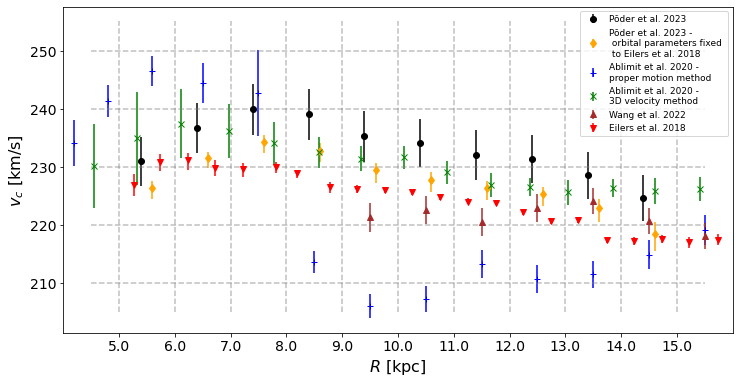

In [70]:
extra_dims = [3, 2]
plot_rotation_curve(False, 
                    [paths[0], paths[1]], 
                    ['Põder et al. 2023',
                    'Põder et al. 2023 - \n orbital parameters fixed \n to Eilers et al. 2018'],
                    [3000, 3000],
                    extra_dims=extra_dims,
                    display_eilers=True,
                    display_bin_edges=True)

plt.savefig("Vc_Curve_Jan.pdf", format='pdf', dpi=300, bbox_inches='tight')


In [ ]:
plot_corner(samplers[1], 3000)

# Results February, 2023

In [4]:
# 100% Data - GPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-02-17-12-19-47_48_full_run_mean_no_halo_stars'

# Eilers comp
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-02-14-17-33-21_Eilers_Comp'
paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (1679257, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 15477828.352779053), (6500.0, 14888999.096845886), (7500.0, 15929148.977418602), (8500.0, 16565445.726879548), (9500.0, 17377168.510338657), (10500.0, 18096276.587770145), (11500.0, 16673771.212839426), (12500.0, 15836050.495158598), (13500.0, 1802

Sampler shape: (15000, 48, 13)


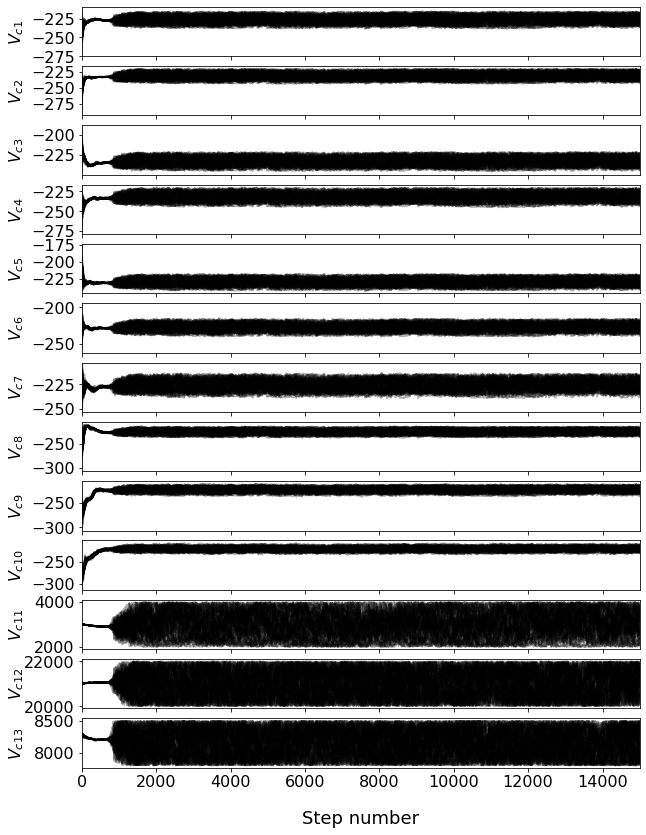

In [33]:
plot_walkers(samplers[0],0)

Sampler shape: (5000, 48, 12)


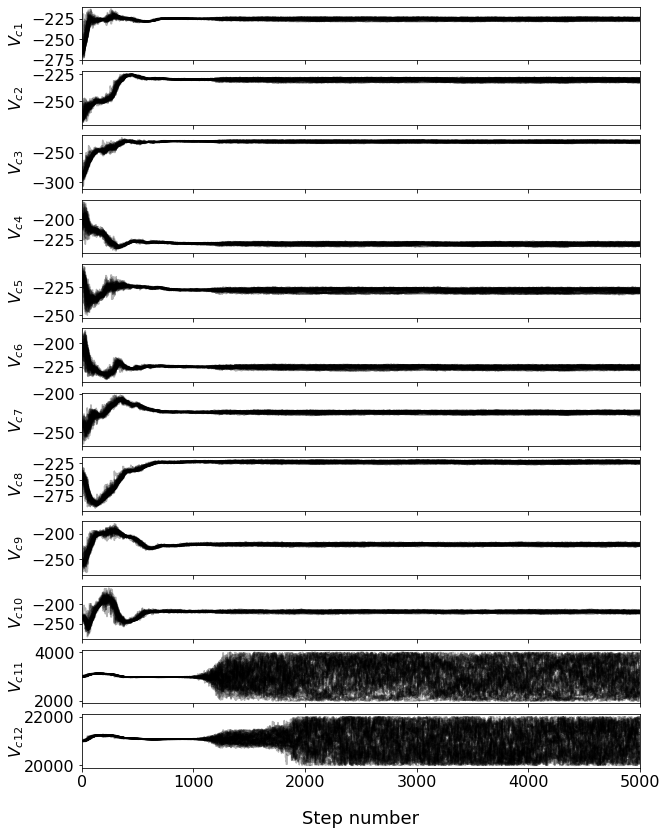

In [26]:
plot_walkers(samplers[1],0)

(624000, 13)
(624000, 4)
['$V_{c}(x=1.03)$', '$h_r$', '$h_\\sigma$', '$R_0$']


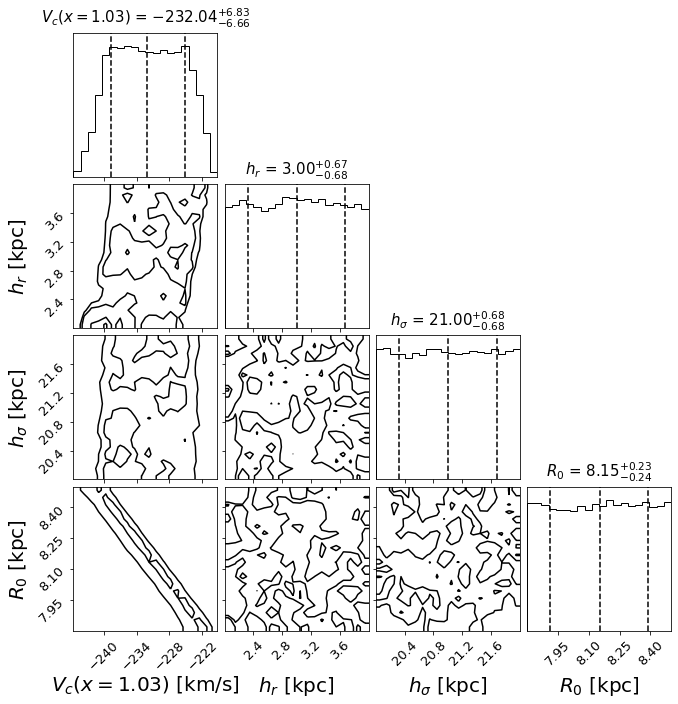

In [32]:
def plot_corner(path, burn_in = 0, plot_name = 'Unnamed', extra_dims = 0, is_save=False):
    
    reader = emcee.backends.HDFBackend(path, read_only=True)
    samples_data = reader.get_chain(discard=burn_in)

    xdf = [num for num in range(0, samples_data.shape[2], 1)]

    if(extra_dims > 0):
        theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

        theta_labels[-3] = r'$h_r$'
        theta_labels[-2] = r'$h_\sigma$'
        theta_labels[-1] = r'$R_0$'
    else:
        theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]
    reader = emcee.backends.HDFBackend(path, read_only=True)
    flatchain = reader.get_chain(flat=True, discard = burn_in)

    # Select only vc4 and other params
    print(flatchain.shape)
    flatchain[:, 10::] = flatchain[:, 10::]/1e3
    flatchain = flatchain[:, [3, 10, 11, 12]]
    print(flatchain.shape)
    theta_labels = [theta_labels[x] for x in [3, 10, 11, 12]]
    theta_labels[0] = r'$V_{c}(x=1.03)$'
    print(theta_labels)

    fig = corner.corner(flatchain, 
                        labels=theta_labels,
                        levels = (1-np.exp(-0.5), 1-np.exp(-2)),
                        plot_datapoints = False,
                        plot_density = False,
                        fill_countours = False,
                        smooth = 0.5,
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, 
                        title_kwargs={"fontsize": 15, 'pad' : 10},
                        label_kwargs=dict(fontsize=20))

    if(extra_dims > 0):
        # theta_labels = [r'$V_{c%s}$ [km/s]' %str(i+1) for i in xdf]
        theta_labels[0] = r'$V_{c}(x=1.03)$ [km/s]'
        theta_labels[-3] = r'$h_r$ [kpc]'
        theta_labels[-2] = r'$h_\sigma$ [kpc]'
        theta_labels[-1] = r'$R_0$ [kpc]'

    y_label_range = np.arange(4, 13, 4)
    x_label_range = np.arange(12, 16, 1)

    y_i = 1
    x_i = 0
    for i, ax in enumerate(fig.get_axes()):
        if i in y_label_range:
            ax.set_ylabel(theta_labels[y_i], labelpad = 15)
            y_i+=1
        if i in x_label_range:
            ax.set_xlabel(theta_labels[x_i], labelpad = 15)
            x_i+=1

        ax.tick_params(axis='both', labelsize=13)


    # def numfmt(x, pos):
    #         s = '{}'.format(x / 1000.0)
    #         return s
    # fmt = ticker.FuncFormatter(numfmt)

    # h_r0_params_yi = [130, 143, 156]
    # h_r0_params_xi = [166, 167, 168]

    # for i, ax in enumerate(fig.get_axes()):
    #     if i in h_r0_params_yi:
    #         ax.yaxis.set_major_formatter(fmt)
    #     if i in h_r0_params_xi:
    #         ax.xaxis.set_major_formatter(fmt)

    if(is_save): 
        plt.savefig(plot_name, dpi=300)
    plt.show()

plot_corner(samplers[0], 2000, extra_dims=3, plot_name='corner_feb.pdf', is_save=True)

In [23]:
y_label_range = np.arange(0, 13, 4)
x_label_range = np.arange(156, 169, 1)
y_label_range

array([ 0,  4,  8, 12])

R, v_c, sig-, sig+
5.5 226.2 6.3 6.3
6.5 231.5 6.6 6.8
7.5 233.0 6.6 6.7
8.5 232.0 6.7 6.8
9.5 229.6 6.6 6.7
10.5 227.8 6.5 6.5
11.5 226.0 6.6 6.7
12.5 225.0 6.3 6.4
13.5 222.6 6.2 6.4
14.5 221.3 5.9 5.9
(10,)
(10,)
R, v_c, sig-, sig+
5.5 225.0 2.0 1.1
6.5 229.7 1.9 1.0
7.5 231.0 2.0 1.2
8.5 229.5 2.1 1.2
9.5 227.2 2.3 1.3
10.5 225.1 2.4 1.3
11.5 223.8 2.2 1.2
12.5 222.4 2.1 1.3
13.5 220.5 2.5 1.7
14.5 218.4 3.0 1.9
(10,)
(10,)
Ablimit et al. 2020 - 
proper motion method
[ 4200.  4800.  5600.  6500.  7500.  8500.  9500. 10500. 11500. 12500.
 13500. 14500. 15500.]
Ablimit et al. 2020 - 
3D velocity method
[ 4560.  5320.  6110.  6970.  7780.  8590.  9330. 10110. 10880. 11670.
 12360. 13040. 13860. 14610. 15420.]
Wang et al. 2022
[ 9500. 10500. 11500. 12500. 13500. 14500. 15500.]
Eilers et al. 2018
[ 5270.  5740.  6230.  6730.  7220.  7820.  8190.  8780.  9270.  9760.
 10260. 10750. 11250. 11750. 12250. 12740. 13230. 13740. 14240. 14740.
 15220. 15740.]
Zhou et al. 2022
[ 5240.  5740.  62

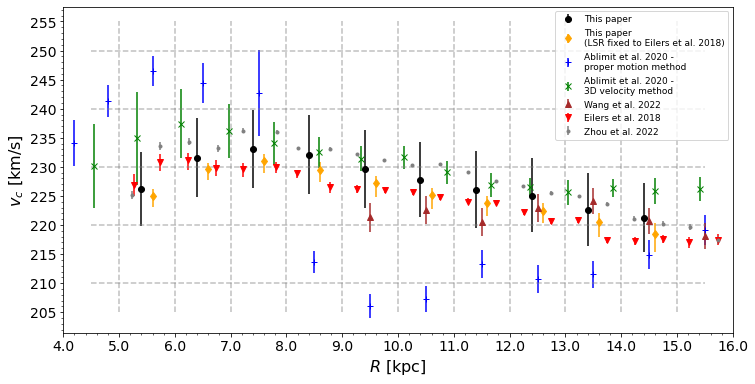

In [5]:
extra_dims = [3, 2]

result_name_1 = 'This paper'
result_name_2 = 'This paper \n(LSR fixed to Eilers et al. 2018)'

plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1,
                    result_name_2],
                    [2000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=True,
                    display_bin_edges=True)

plt.savefig("Vc_Curve_Feb.pdf", format='pdf', dpi=300, bbox_inches='tight')

# Results March, 2023

In [5]:
# Fitting R0 - parallax over error > 5
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-13-13-35-56_48_full_run_parallax_cut_5'

# Eilers Comp - parallax over error > 5
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-16-12-31-44_48_EILERS_COMPARISON_w_cut_5'

# Maria Eilers Comp - parallax over error > 5
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-16-12-31-12_halo_stars_v_dif_mean_w_dw5_EILERS_COMPARISON'

paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-13-13-35-56_48_full_run_parallax_cut_5/sampler_2023-03-13-13-35-56.h5
/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-16-12-31-12_halo_stars_v_dif_mean_w_dw5_EILERS_COMPARISON/sampler_2023-03-16-12-31-12.h5
1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (1614919, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info=

Sampler shape: (4000, 48, 12)


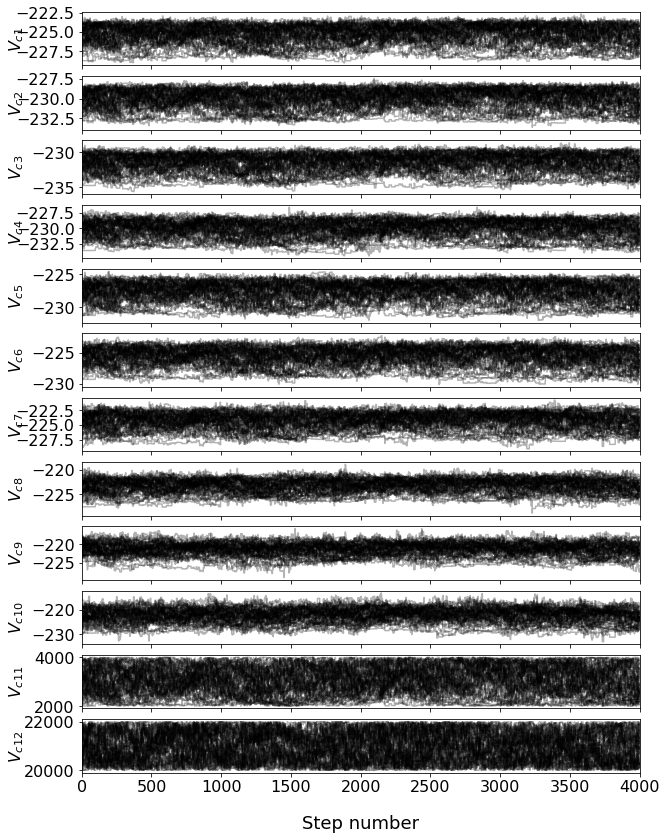

In [77]:
plot_walkers(samplers[1], 4000)

(192000, 12)
(192000, 12)
['$V_{c1}$', '$V_{c2}$', '$V_{c3}$', '$V_{c4}$', '$V_{c5}$', '$V_{c6}$', '$V_{c7}$', '$V_{c8}$', '$V_{c9}$', '$h_r$', '$h_\\sigma$', '$R_0$']


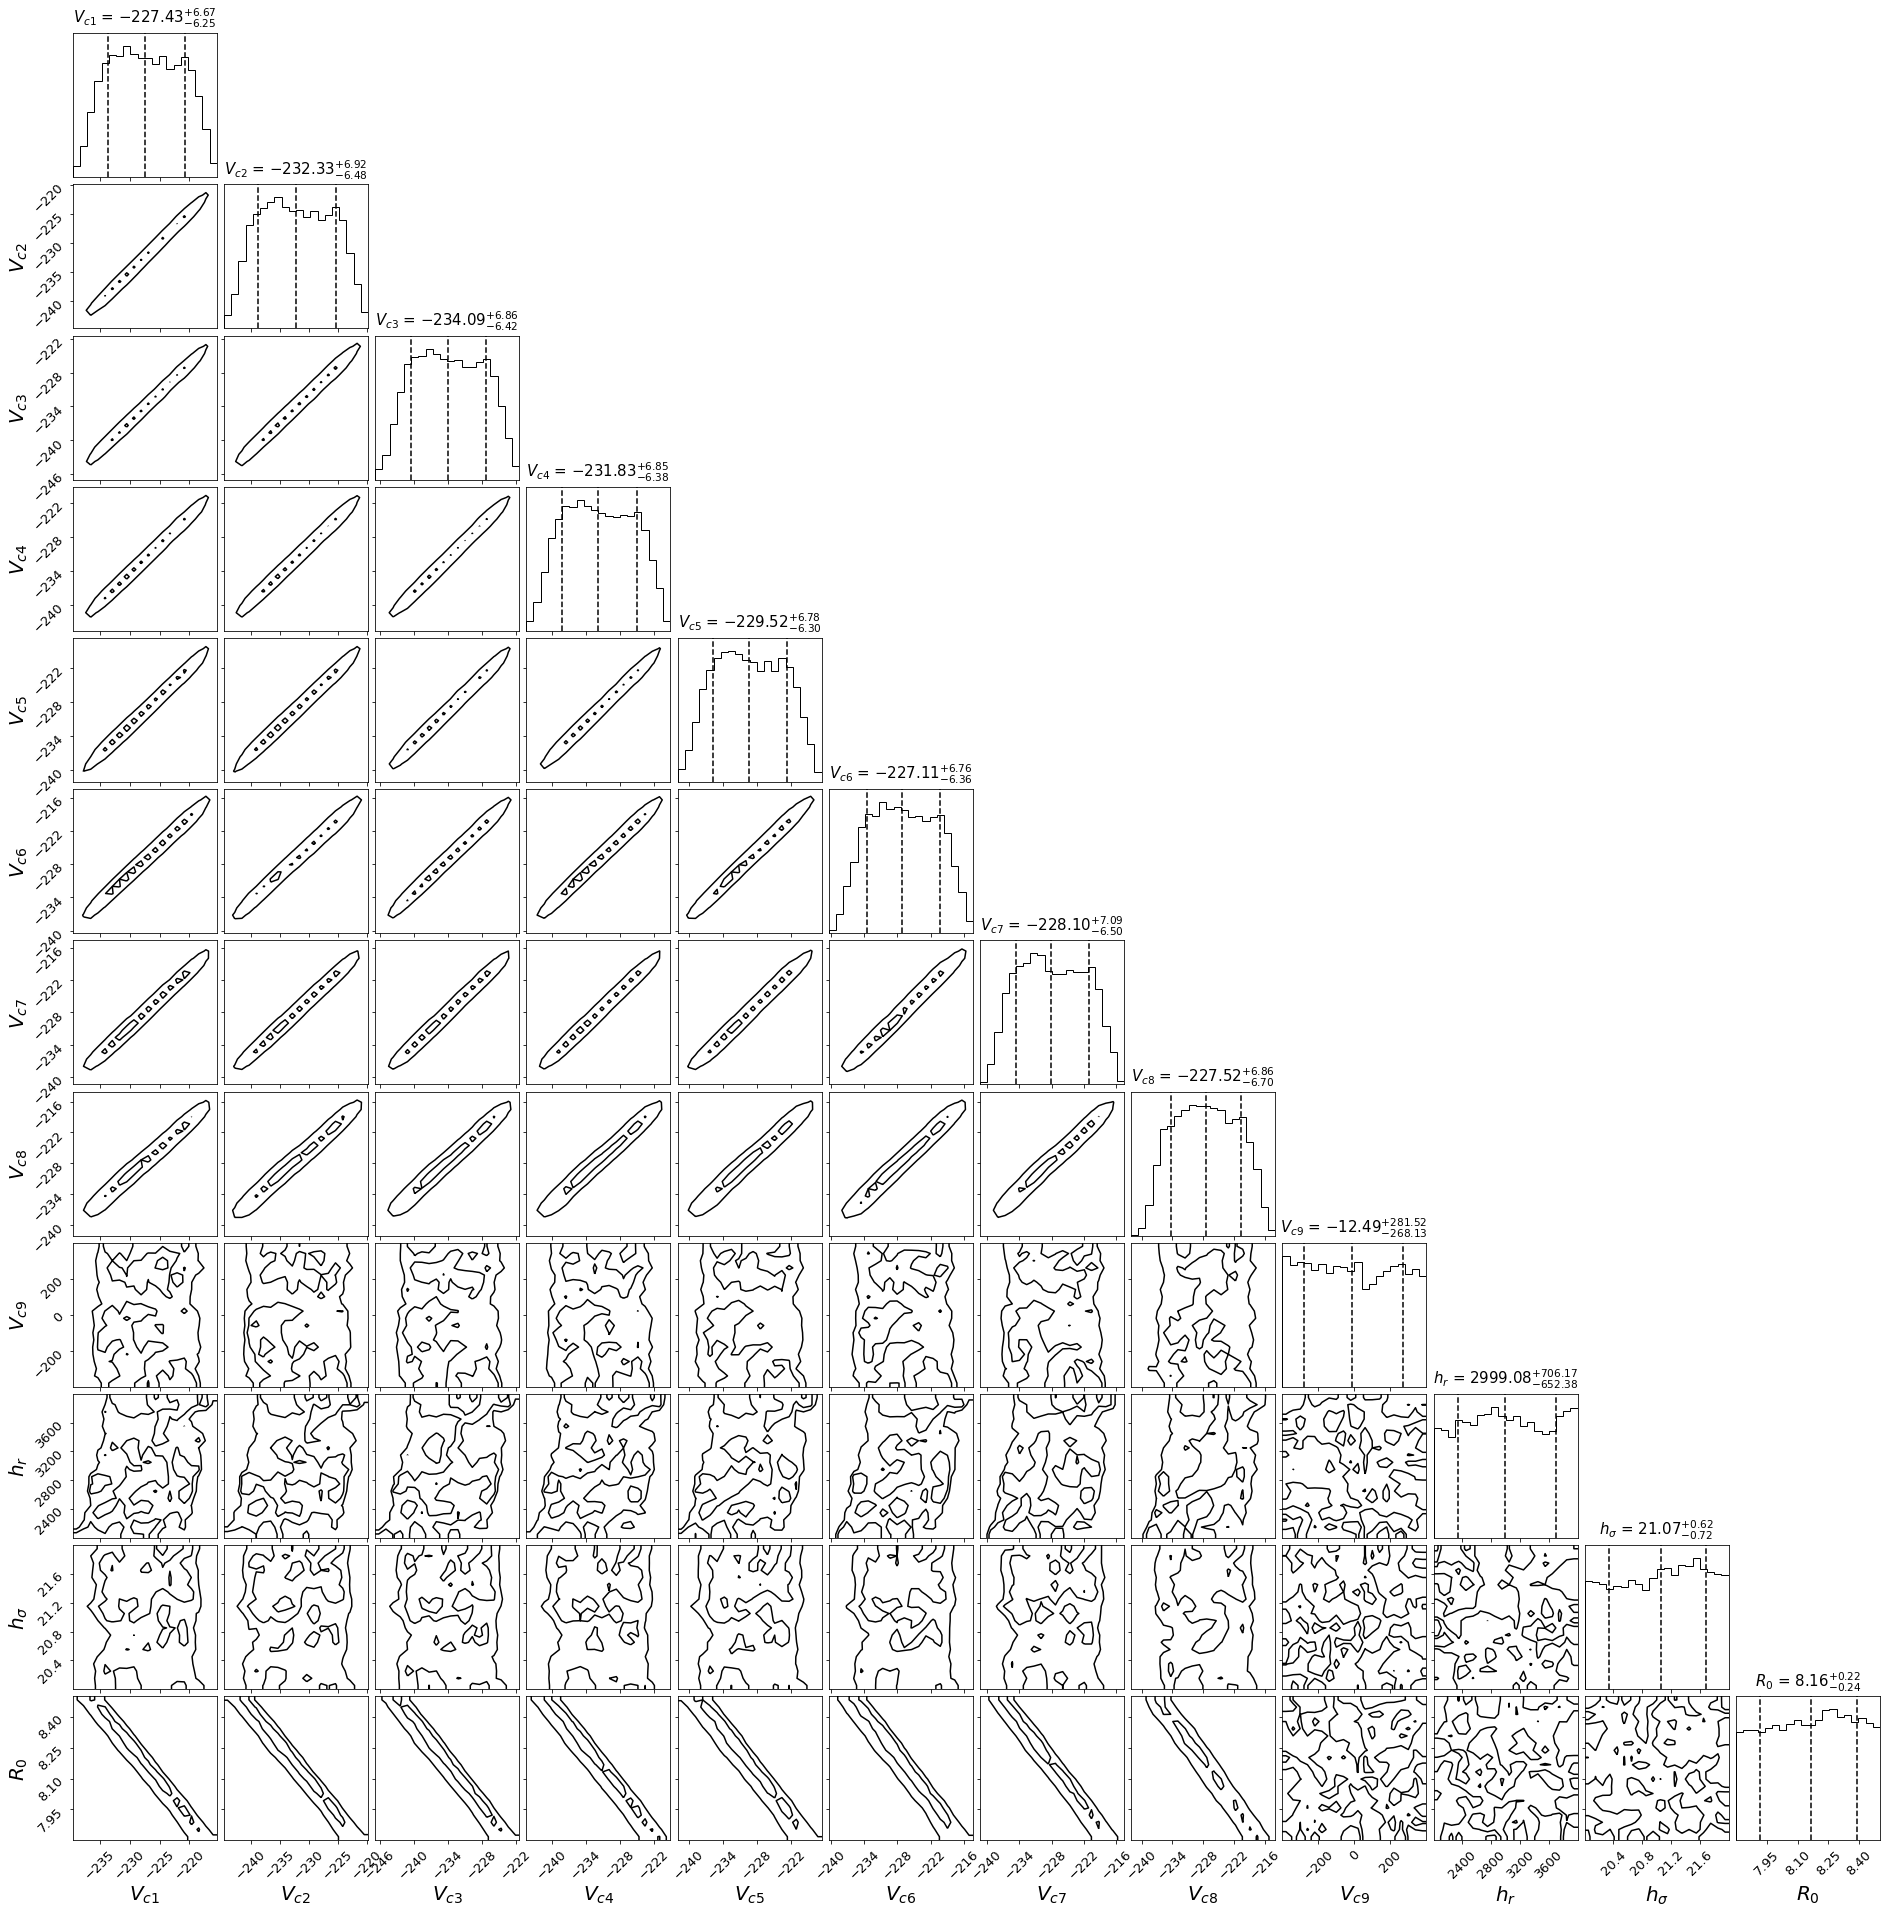

In [38]:
def plot_corner(path, burn_in = 0, plot_name = 'Unnamed', extra_dims = 0, is_save=False):
    
    reader = emcee.backends.HDFBackend(path, read_only=True)
    samples_data = reader.get_chain(discard=burn_in)

    xdf = [num for num in range(0, samples_data.shape[2], 1)]

    if(extra_dims > 0):
        theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

        theta_labels[-3] = r'$h_r$'
        theta_labels[-2] = r'$h_\sigma$'
        theta_labels[-1] = r'$R_0$'
    else:
        theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]
    reader = emcee.backends.HDFBackend(path, read_only=True)
    flatchain = reader.get_chain(flat=True, discard = burn_in)

    # Select only vc4 and other params
    print(flatchain.shape)
    flatchain[:, 10::] = flatchain[:, 10::]/1e3
    #flatchain = flatchain[:, [3, 10, 11, 12]]
    print(flatchain.shape)
    # theta_labels = [theta_labels[x] for x in [3, 10, 11, 12]]
    # theta_labels[0] = r'$V_{c}(x=1.03)$'
    print(theta_labels)

    fig = corner.corner(flatchain, 
                        labels=theta_labels,
                        levels = (1-np.exp(-0.5), 1-np.exp(-2)),
                        plot_datapoints = False,
                        plot_density = False,
                        fill_countours = False,
                        smooth = 0.5,
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, 
                        title_kwargs={"fontsize": 15, 'pad' : 10},
                        label_kwargs=dict(fontsize=20))

    if(extra_dims > 0):
        # theta_labels = [r'$V_{c%s}$ [km/s]' %str(i+1) for i in xdf]
        theta_labels[0] = r'$V_{c}(x=1.03)$ [km/s]'
        theta_labels[-3] = r'$h_r$ [kpc]'
        theta_labels[-2] = r'$h_\sigma$ [kpc]'
        theta_labels[-1] = r'$R_0$ [kpc]'

    y_label_range = np.arange(4, 13, 4)
    x_label_range = np.arange(12, 16, 1)

    y_i = 1
    x_i = 0
    for i, ax in enumerate(fig.get_axes()):
        # if i in y_label_range:
        #     ax.set_ylabel(theta_labels[y_i], labelpad = 15)
        #     y_i+=1
        # if i in x_label_range:
        #     ax.set_xlabel(theta_labels[x_i], labelpad = 15)
        #     x_i+=1

        ax.tick_params(axis='both', labelsize=13)

    if(is_save): 
        plt.savefig(plot_name, dpi=300)
    plt.show()

plot_corner(samplers[1], 2000, extra_dims=3, plot_name='corner_march.pdf', is_save=False)

R, v_c, sig-, sig+
5.5 226.4 6.5 6.3
6.5 231.7 6.8 6.7
7.5 233.4 6.8 6.7
8.5 232.5 6.8 6.7
9.5 229.9 6.7 6.7
10.5 228.1 6.6 6.5
11.5 226.3 6.8 6.7
12.5 225.8 6.6 6.4
13.5 223.7 6.3 6.4
14.5 222.7 6.7 7.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 225.1 1.7 1.0
6.5 229.8 1.7 1.0
7.5 231.2 1.8 1.1
8.5 229.8 1.9 1.2
9.5 227.3 2.1 1.2
10.5 225.3 2.0 1.3
11.5 224.1 2.0 1.2
12.5 223.1 1.9 1.2
13.5 221.1 2.1 1.5
14.5 221.9 3.6 2.6
(10,)
(10,)
Ablimit et al. 2020 - 
proper motion method
[ 4200.  4800.  5600.  6500.  7500.  8500.  9500. 10500. 11500. 12500.
 13500. 14500. 15500.]
Ablimit et al. 2020 - 
3D velocity method
[ 4560.  5320.  6110.  6970.  7780.  8590.  9330. 10110. 10880. 11670.
 12360. 13040. 13860. 14610. 15420.]
Wang et al. 2022
[ 9500. 10500. 11500. 12500. 13500. 14500. 15500.]
Eilers et al. 2018
[ 5270.  5740.  6230.  6730.  7220.  7820.  8190.  8780.  9270.  9760.
 10260. 10750. 11250. 11750. 12250. 12740. 13230. 13740. 14240. 14740.
 15220. 15740.]
Zhou et al. 2022
[ 5240.  5740.  62

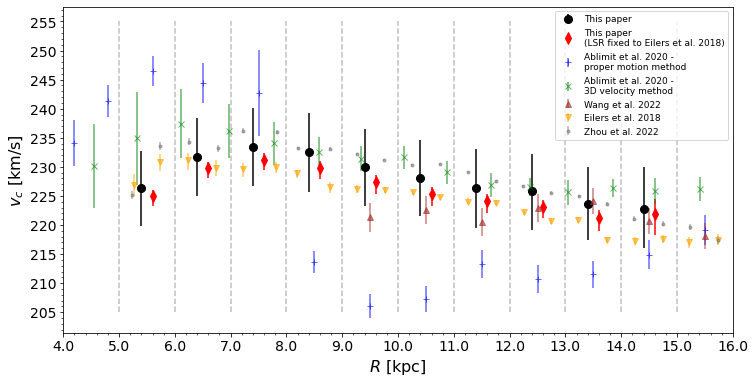

In [6]:
extra_dims = [3, 2]

result_name_1 = 'This paper'
result_name_2 = 'This paper \n(LSR fixed to Eilers et al. 2018)'



plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [2000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=True,
                    display_bin_edges=True)

#plt.savefig("Vc_Curve_Feb.pdf", format='pdf', dpi=300, bbox_inches='tight')

R, v_c, sig-, sig+
5.5 226.4 6.5 6.3
6.5 231.7 6.8 6.7
7.5 233.4 6.8 6.7
8.5 232.5 6.8 6.7
9.5 229.9 6.7 6.7
10.5 228.1 6.6 6.5
11.5 226.3 6.8 6.7
12.5 225.8 6.6 6.4
13.5 223.7 6.3 6.4
14.5 222.7 6.7 7.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 225.1 1.7 1.0
6.5 229.8 1.7 1.0
7.5 231.2 1.8 1.1
8.5 229.8 1.9 1.2
9.5 227.3 2.1 1.2
10.5 225.3 2.0 1.3
11.5 224.1 2.0 1.2
12.5 223.1 1.9 1.2
13.5 221.1 2.1 1.5
14.5 221.9 3.6 2.6
(10,)
(10,)
Ablimit et al. 2020 - 
proper motion method
[ 4200.  4800.  5600.  6500.  7500.  8500.  9500. 10500. 11500. 12500.
 13500. 14500. 15500.]
Ablimit et al. 2020 - 
3D velocity method
[ 4560.  5320.  6110.  6970.  7780.  8590.  9330. 10110. 10880. 11670.
 12360. 13040. 13860. 14610. 15420.]
Wang et al. 2022
[ 9500. 10500. 11500. 12500. 13500. 14500. 15500.]
Eilers et al. 2018
[ 5270.  5740.  6230.  6730.  7220.  7820.  8190.  8780.  9270.  9760.
 10260. 10750. 11250. 11750. 12250. 12740. 13230. 13740. 14240. 14740.
 15220. 15740.]
Zhou et al. 2022
[ 5240.  5740.  62

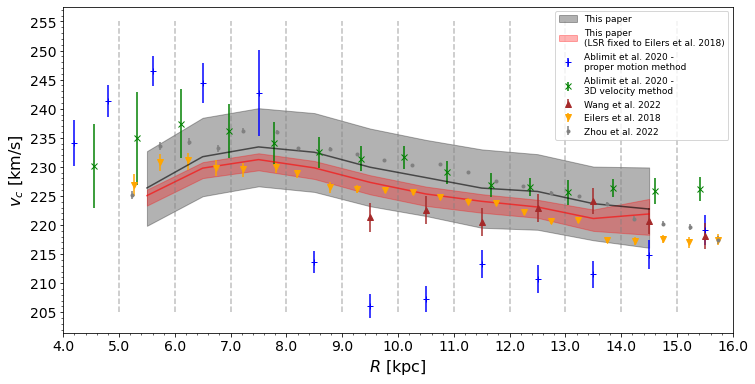

In [85]:
plot_rotation_curve_shaded([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [2000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=True,
                    display_bin_edges=True)

## Additional Checks

### R0 at extremes

In [24]:
# Fitting R0 - parallax over error > 5
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-13-13-35-56_48_full_run_parallax_cut_5'

# Eilers Comp - parallax over error > 5
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-16-12-31-44_48_EILERS_COMPARISON_w_cut_5'

path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-04-26-10-35-13_48_R0_8500_CHECK_fixed'

path4 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-04-26-10-33-41_48_R0_7800_CHECK_fixed'

paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']


/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-13-13-35-56_48_full_run_parallax_cut_5/sampler_2023-03-13-13-35-56.h5
/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-16-12-31-44_48_EILERS_COMPARISON_w_cut_5/sampler_2023-03-16-12-31-44.h5
1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (1614919, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 151776

Sampler shape: (8000, 48, 12)


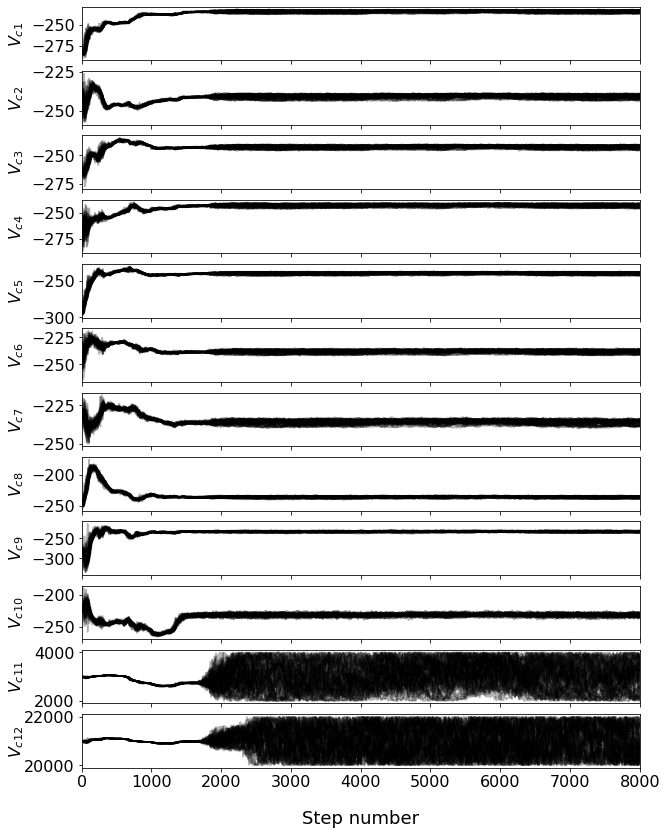

Sampler shape: (8000, 48, 12)


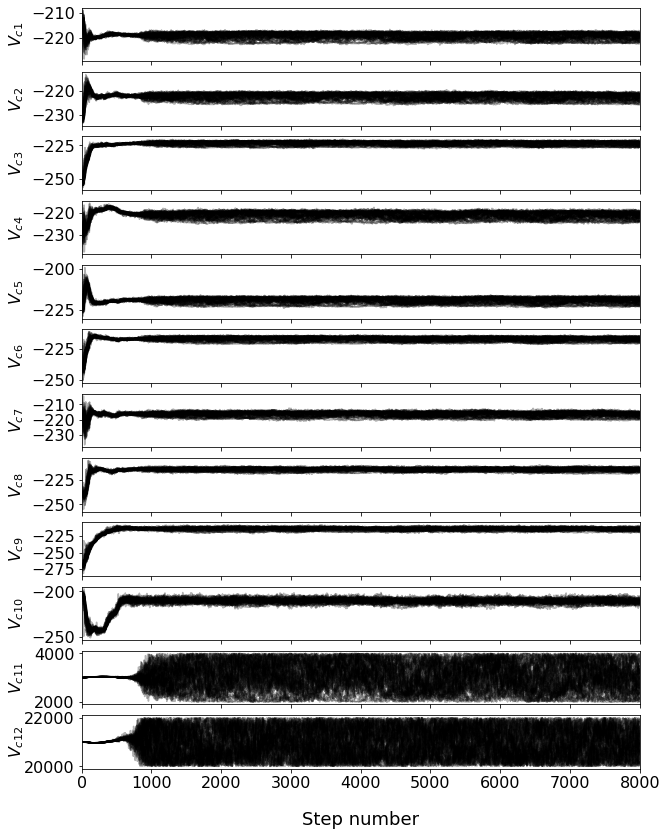

In [25]:
sampler = path3 +'/sampler_' + path3.split('/')[-1].split('_')[0] + '.h5'

plot_walkers(sampler, 0)

sampler = path4 +'/sampler_' + path4.split('/')[-1].split('_')[0] + '.h5'

plot_walkers(sampler, 0)

R, v_c, sig-, sig+
5.5 226.4 6.5 6.3
6.5 231.7 6.8 6.7
7.5 233.4 6.8 6.7
8.5 232.5 6.8 6.7
9.5 229.9 6.7 6.7
10.5 228.1 6.6 6.5
11.5 226.3 6.8 6.7
12.5 225.8 6.6 6.4
13.5 223.7 6.3 6.4
14.5 222.7 6.7 7.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 225.1 1.8 1.1
6.5 229.9 1.7 1.1
7.5 231.4 1.8 1.1
8.5 229.9 1.9 1.2
9.5 227.5 2.0 1.3
10.5 225.4 2.1 1.4
11.5 224.2 1.9 1.3
12.5 223.2 1.8 1.3
13.5 221.3 2.1 1.6
14.5 222.0 3.6 2.8
(10,)
(10,)
R, v_c, sig-, sig+
5.5 233.5 1.7 1.0
6.5 240.5 1.6 0.9
7.5 242.5 1.7 1.0
8.5 242.3 1.7 1.1
9.5 239.7 1.9 1.1
10.5 237.8 1.9 1.2
11.5 235.6 1.8 1.2
12.5 235.5 1.7 1.1
13.5 233.3 1.8 1.4
14.5 231.3 2.4 2.0
[ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
(10,)
(10,)
R, v_c, sig-, sig+
5.5 218.9 1.7 1.1
6.5 222.2 1.8 1.2
7.5 223.3 1.9 1.2
8.5 220.8 2.1 1.3
9.5 218.9 2.2 1.4
10.5 216.4 2.2 1.4
11.5 216.2 2.0 1.3
12.5 214.2 2.0 1.4
13.5 213.6 2.7 2.0
14.5 210.2 2.7 2.4
[ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
(10,

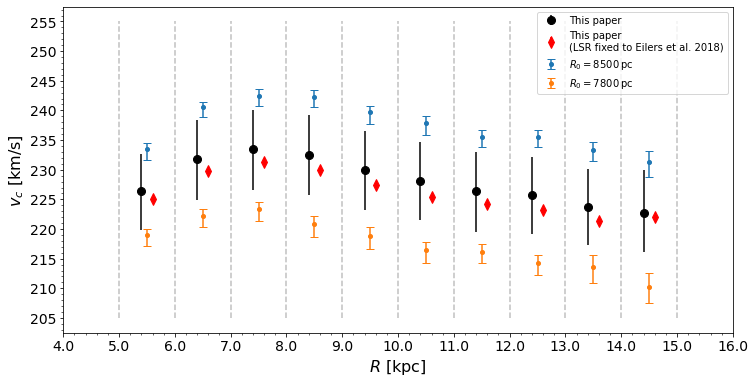

In [48]:
extra_dims = [3, 2]

result_name_1 = 'This paper'
result_name_2 = 'This paper \n(LSR fixed to Eilers et al. 2018)'



plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [2000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

labels = [r'$R_0 = 8500 \rm \, pc$', r'$R_0 = 7800 \rm \, pc$']

extra_dims = [2, 2]
burnin = [3000, 3000]
for i_path, path in enumerate([path3, path4]):

    path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
    reader = emcee.backends.HDFBackend(path, read_only=True)
    samples_data = reader.get_chain(discard=burnin[i_path])
    flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

    bin_velocities = []
    ndim = samples_data.shape[2]

    if(len(extra_dims) > 0):
        ndim = samples_data.shape[2] - extra_dims[i_path]
    
    print('R, v_c, sig-, sig+')
    for i in range(ndim):
        mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
        v_med = np.median(flatchain[:, i])
        bin_velocities.append((v_med, v_sub, v_sup))

        print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
    velocity_array = np.array(bin_velocities)

    # if(len(mcmc_runs) == 0):
    #     x_offset = 0
    #     x_values = bin_centers_r + x_offset
    # else:
    #     x_offset = np.linspace(-100, 100, len(mcmc_runs))
    #     x_values = bin_centers_r + x_offset[i_path]
    y_values = velocity_array[:,0]
    y_error = [velocity_array[:,1], velocity_array[:,2]]
    x_values = bin_setup['bin_centers_r']

    print(x_values)

    print(x_values.shape)
    print(y_values.shape)

    plt.errorbar(x_values, -y_values, fmt='o',
                yerr= y_error, label=labels[i_path], linestyle='', capsize=4,
                markersize = 4)
    plt.legend()
    plt.savefig('RC_R0_7.8_8.5.pdf', dpi=300)

In [21]:
y_values

array([-232.47425914, -235.59691447, -236.62033289, -234.15869929,
       -232.17727674, -229.70497816, -229.57040099, -227.64580297,
       -226.61456856, -223.54097382])

### Parallax/error > 8

In [14]:
# Fitting R0 - parallax over error > 8
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-19-18-15-45_48_full_run_parallax_cut_8_merged_bins'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']
bin_edges_r = bin_setup['bin_edges'][0][0]

/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-19-18-15-45_48_full_run_parallax_cut_8_merged_bins/sampler_2023-03-19-18-15-45.h5
1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (1458247, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 14687411.8020973), (6500.0, 14926859.838079581), (7500.0, 16162981.33103485), (8500.0, 16777767.40183661), (9500.0, 

Sampler shape: (6000, 48, 12)


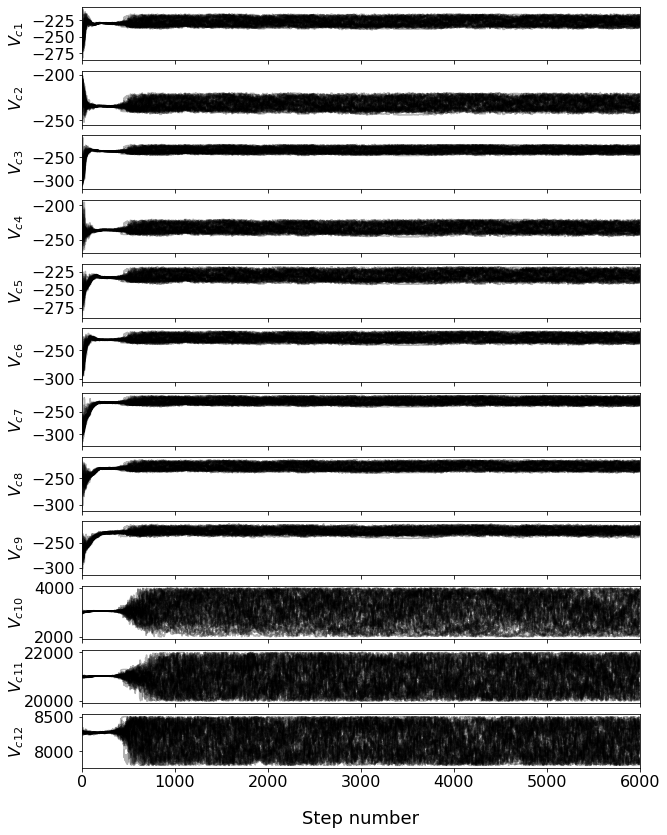

In [8]:
plot_walkers(samplers[0], 0)

In [32]:
np.delete(bin_centers_r,-1).shape


(9,)

R, v_c, sig-, sig+
5.5 226.8 6.6 6.8
6.5 231.9 6.7 7.1
7.5 233.8 6.8 7.0
8.5 232.9 6.8 7.1
9.5 230.2 6.7 7.0
10.5 228.4 6.5 6.9
11.5 227.1 6.9 7.1
12.5 227.9 6.9 7.0
14.0 227.1 6.2 6.8
(9,)
(9,)
Ablimit et al. 2020 - 
proper motion method
[ 4200.  4800.  5600.  6500.  7500.  8500.  9500. 10500. 11500. 12500.
 13500. 14500. 15500.]
Ablimit et al. 2020 - 
3D velocity method
[ 4560.  5320.  6110.  6970.  7780.  8590.  9330. 10110. 10880. 11670.
 12360. 13040. 13860. 14610. 15420.]
Wang et al. 2022
[ 9500. 10500. 11500. 12500. 13500. 14500. 15500.]
Eilers et al. 2018
[ 5270.  5740.  6230.  6730.  7220.  7820.  8190.  8780.  9270.  9760.
 10260. 10750. 11250. 11750. 12250. 12740. 13230. 13740. 14240. 14740.
 15220. 15740.]
Zhou et al. 2022
[ 5240.  5740.  6250.  6770.  7230.  7830.  8210.  8780.  9260.  9750.
 10250. 10750. 11250. 11750. 12240. 12740. 13250. 13740. 14230. 14740.
 15230. 15740.]


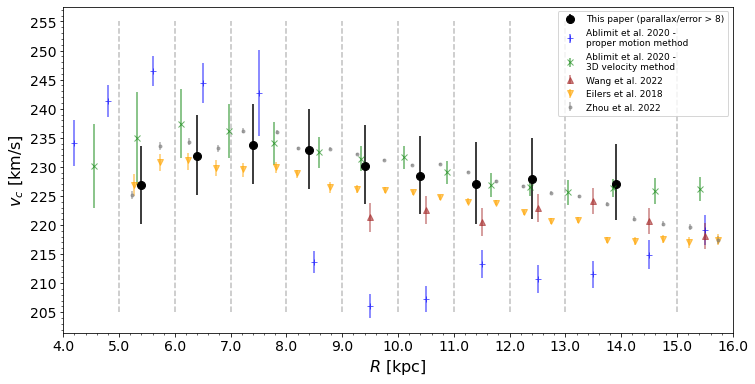

In [56]:
extra_dims = [3]

result_name_1 = 'This paper (parallax/error > 8)'
result_name_2 = 'This paper \n(LSR fixed to Eilers et al. 2018)'



plot_rotation_curve([paths[0]], 
                    [result_name_1],
                    [2000],
                    extra_dims=extra_dims,
                    display_eilers=True,
                    display_bin_edges=True,
                    is_last_merged=True)

#plt.savefig("Vc_Curve_Feb.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [41]:
def get_velocity_curve_data(mcmc_run, 
                            burnin, 
                            extra_dims=[], 
                            is_last_merged=False):
    
    bin_setup = load_bin_settings(mcmc_run, is_print=False)
    bin_centers_r = bin_setup['bin_centers_r']

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    path = mcmc_run
    path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
    reader = emcee.backends.HDFBackend(path, read_only=True)
    samples_data = reader.get_chain(discard=burnin)
    flatchain = reader.get_chain(flat=True, discard = burnin)

    bin_velocities = []
    ndim = samples_data.shape[2]

    if(extra_dims > 0):
        ndim = samples_data.shape[2] - extra_dims
    
    print('R, v_c, sig-, sig+')
    for i in range(ndim):
        mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
        v_med = np.median(flatchain[:, i])
        bin_velocities.append((v_med, v_sub, v_sup))

        print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
    velocity_array = np.array(bin_velocities)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    if(is_last_merged):
            # Remove middle boundary
            bin_edges_r = np.delete(bin_edges_r, -2)
    print('Bin edges:')
    print(bin_edges_r)

    return bin_centers_r, velocity_array


In [48]:
r, vc_data = get_velocity_curve_data(paths[0], 2000, 3, True)
print('Bin centers: {}'.format(r))

from scipy.stats import linregress
linear_reg_result = linregress(r/1e3, np.abs(vc_data[:,0]))
linear_reg_result


R, v_c, sig-, sig+
5.5 226.8 6.6 6.8
6.5 231.9 6.7 7.1
7.5 233.8 6.8 7.0
8.5 232.9 6.8 7.1
9.5 230.2 6.7 7.0
10.5 228.4 6.5 6.9
11.5 227.1 6.9 7.1
12.5 227.9 6.9 7.0
14.0 227.1 6.2 6.8
Bin edges:
[ 5000.  6000.  7000.  8000.  9000. 10000. 11000. 12000. 13000. 15000.]
Bin centers: [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 14000.]


LinregressResult(slope=-0.4665045872923635, intercept=234.0185103110548, rvalue=-0.4879245239482052, pvalue=0.1826954151284561, stderr=0.3154363154808874)

In [53]:
linear_reg_result[0]*r/1e3+linear_reg_result[1]

array([231.45273508, 230.98623049, 230.51972591, 230.05322132,
       229.58671673, 229.12021214, 228.65370756, 228.18720297,
       227.48744609])

# Uncertainity in streaming motion

In [24]:
# Streaming motion (6.8+6.7)/2

v_stream = 251.5 - 12.24 - 232.5
v_stream

6.759999999999991

In [25]:
sig_vtot = 1
sig_vc = (6.7+6.8)/2
sig_odot_lsr = 0.47

In [26]:
unc_stream = np.sqrt(sig_vtot**2 + sig_vc**2 + sig_odot_lsr**2)
np.round(unc_stream, 2)

6.84